In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Evaluating the fit of stationary vs nonstationary gaussian processes
Fitting a stationary model helps avoid small eigenvlues when cov mat is computed with a small number of patches

In [13]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_patches_to_use = onp.array([10, 33, 100, 333, 1000, 3333, 10000])
# num_patches_to_use = onp.array([2, 8, 32, 128, 512, 2048, 8192])
num_patches = num_patches_to_use.max()
num_test_set_patches = 4000
num_images = num_patches
num_bootstraps = 10
# channel = 'DPC_Right'
channel = 'LED119'
eigenvalue_floor = 1e-3

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_set_patches, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_set_images = all_images[num_images:]
patches = extract_patches(images, patch_size, num_patches=num_patches)
test_set_patches = extract_patches(test_set_images, patch_size, num_patches=num_test_set_patches)

cov_mats = {}
non_stationary_means = {}
stationary_means = {}
cov_mats_stationary = {}
cov_mats_stationary_optimized = {}
for n_patches in tqdm(num_patches_to_use):
    cov_mats[n_patches] = []
    non_stationary_means[n_patches] = []
    stationary_means[n_patches] = []
    cov_mats_stationary[n_patches] = []
    cov_mats_stationary_optimized[n_patches] = []
    for i in range(num_bootstraps):
        patch_indices = onp.random.choice(np.arange(patches.shape[0]), n_patches, replace=False)
        bootstrapped_patches = patches[patch_indices]
        cov_mat = make_positive_definite(estimate_cov_mat(bootstrapped_patches), eigenvalue_floor=eigenvalue_floor)
        non_stationary_mean = np.mean(bootstrapped_patches, axis=0).flatten()
        stationary_mean = non_stationary_mean * np.ones_like(non_stationary_mean)
        cov_mat_stationary = estimate_stationary_cov_mat(bootstrapped_patches)
        cov_mat_stationary_optimized = estimate_stationary_cov_mat(bootstrapped_patches, optimize=True)

        cov_mats[n_patches].append(cov_mat)
        non_stationary_means[n_patches].append(non_stationary_mean)
        stationary_means[n_patches].append(stationary_mean)
        cov_mats_stationary[n_patches].append(cov_mat_stationary)
        cov_mats_stationary_optimized[n_patches].append(cov_mat_stationary_optimized)


  0%|          | 0/7 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -1221.3068430582093
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.'
/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -528.7625309867055
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.'
/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -4719.301231640952
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using po

Text(0.5, 0.98, 'Eigenvalues of stationary and non-stationary covariance matrices vs dataset size (10x10 patches)')

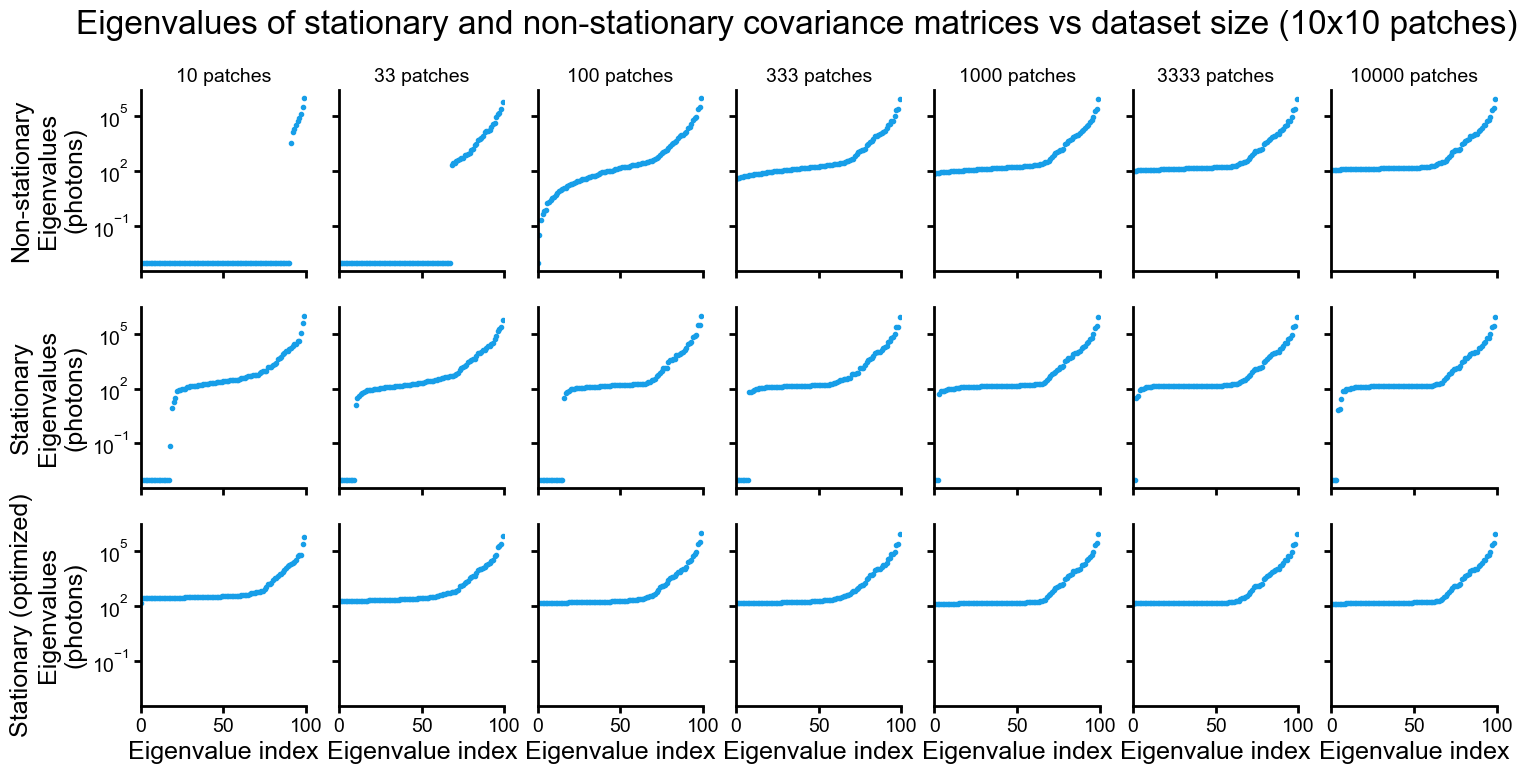

: 

In [14]:
fig, ax = plt.subplots(3, num_patches_to_use.shape[0], figsize=(num_patches_to_use.shape[0] * 2.5, 8), sharex=True, sharey=True)

for i, n_patches in enumerate(num_patches_to_use):
    eigs = np.linalg.eigvalsh(cov_mats[n_patches][0])
    eigs_stationary = np.linalg.eigvalsh(cov_mats_stationary[n_patches][0])
    eigs_stationary_optimized = np.linalg.eigvalsh(cov_mats_stationary_optimized[n_patches][0])
    ax[0, i].semilogy(eigs, '.')
    ax[1, i].semilogy(eigs_stationary, '.')
    ax[2, i].semilogy(eigs_stationary_optimized, '.')
    clear_spines(ax[0, i])
    clear_spines(ax[1, i])
    clear_spines(ax[2, i])
    

    ax[0, i].set_title(f'{n_patches} patches')
    if i == 0:
        ax[0, i].set_ylabel('Non-stationary\nEigenvalues\n(photons)')
        ax[1, i].set_ylabel('Stationary\nEigenvalues\n(photons)')
        ax[2, i].set_ylabel('Stationary (optimized)\nEigenvalues\n(photons)')
    ax[-1, i].set(xlabel='Eigenvalue index', xlim=[0, len(eigs)])


fig.suptitle('Eigenvalues of stationary and non-stationary covariance matrices vs dataset size ({}x{} patches)'.format(patch_size, patch_size))